In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [4]:
def plot_training_chart(history, key, figsize=None):
  figsize = figsize or (10, 5)
  epochs = [i for i in history.epoch]
  fig , ax = plt.subplots(1, 1, figsize=figsize)
  train_metrics = history.history[key]
  val_metrics = history.history['val_' + key]
  if key =='loss':
    train_metrics = np.array(train_metrics)/sum(train_metrics)
    val_metrics = np.array(val_metrics)/sum(val_metrics)
  ax.plot(epochs , train_metrics , label = f'Training {key}')
  ax.plot(epochs , val_metrics, label = f'Validation {key}')
  ax.set_title(f'Training & validation {key}')
  ax.legend()
  ax.set_xlabel("Epochs")
  ax.set_ylabel(f"{key}")
  plt.show()

def plot_stream(dset, p, s, eq, 
                is_test=False, thres=.5, 
                figsize=None):
  fig, ax = plt.subplots(4 if is_test else 3,1, figsize=(figsize))
  plt.tight_layout()

  for i in range(3):
    ymin, ymax = ax[i].get_ylim()
    xtr = ax[i].get_xaxis_transform()  
    ax[i].plot(np.array(dset)[:,i], 'k')
    ax[i].vlines(dset.attrs['p_arrival_sample'], ymin, ymax, color='b', transform=xtr, label='P-arrival')
    ax[i].vlines(dset.attrs['s_arrival_sample'], ymin, ymax, color='r', transform=xtr, label='S-arrival')
    ax[i].vlines(dset.attrs['coda_end_sample'], ymin, ymax, color='aqua', transform=xtr, label='Coda End')
    ax[i].set_xticklabels([])
    ax[i].set_ylabel('Amplitude')
    plt.tight_layout()
    if i==0:
      ax[i].set_title(ev)

  if is_test:
    p_p,s_p,eq_p = p.copy(), s.copy(), eq.copy()
    p_p[p_p<thres] = 0
    s_p[s_p<thres] = 0
    eq_p[eq_p<thres] = 0

    ax[3].plot(p_p, 'b--', label='P_arrival')
    ax[3].plot(s_p, 'r--', label='S_arrival')
    ax[3].plot(eq_p, 'g--', label='Earthquake')
    ax[3].set_ylabel('Probability')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3)
    plt.tight_layout()


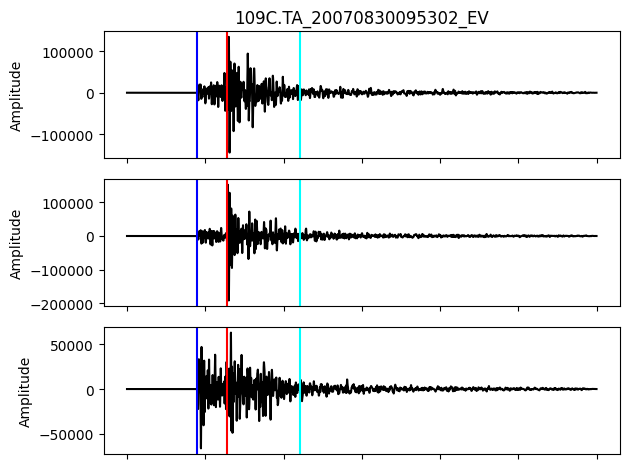

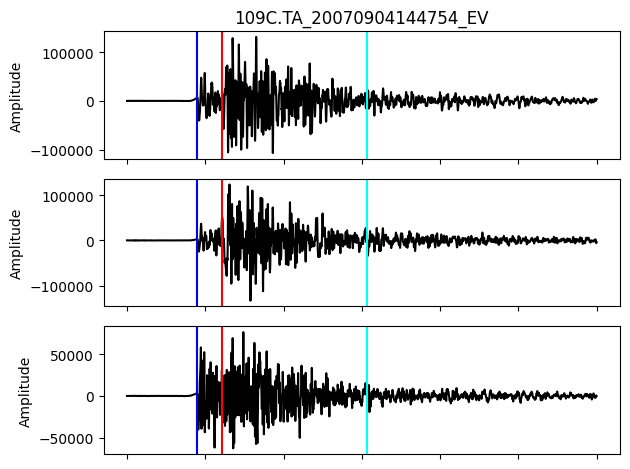

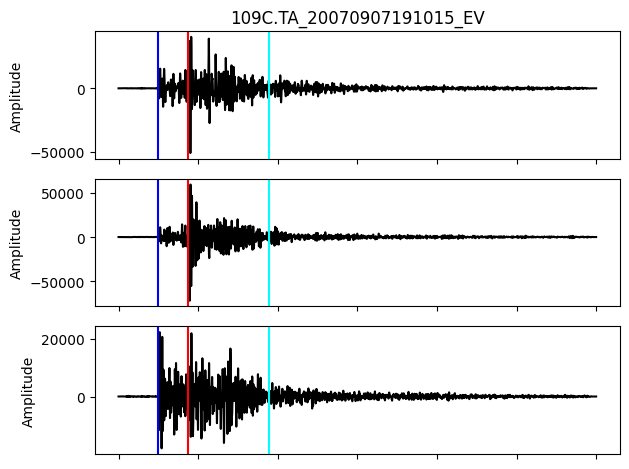

In [5]:
import h5py
import os

csv_path = os.path.join('data','chunk2_ev.1069.csv')
h5_path = os.path.join('data','chunk2_ev.1069.hdf5')
metadata = pd.read_csv(csv_path)
ev_list = metadata['trace_name'].to_list()

h5 = h5py.File(h5_path, 'r')
for ev in ev_list[:3]:
  dset = h5.get(f'data/{ev}')
  times = np.array(dset.attrs['times'])
  p = dset.attrs['p_arrival_sample']
  s = dset.attrs['s_arrival_sample']
  eq = dset.attrs['coda_end_sample']
  
  plot_stream(dset, p,s,eq)

  # export an event as a csv
  # p_time = dset.attrs['p_arrival_sample'].astype(int)
  # coda_time = dset.attrs['coda_end_sample'][0][0].astype(int)

  # y_ = np.zeros((len(times),))
  # y_[p_time:coda_time+1] = 1
  # y_

  # dfd = {'timestamp': times, 'is_eq': y_.astype(int)}
  # for i,c in enumerate(['HHE', 'HHN', 'HHZ']):
  #   dfd[c] = np.array(dset)[:,i]

  # out_path = os.path.join('data', 'csv', f'{ev}.csv')
  # pd.DataFrame(dfd).to_csv(out_path, index=None)

In [ ]:
TIMESTEPS = 6000

X, label_p, label_s, label_eq = [], [], [], []

for ev in ev_list:
    dset = h5.get(f'data/{ev}')

    X.append(np.array(dset))

    y_ = np.zeros((TIMESTEPS,))
    time_p = dset.attrs['p_arrival_sample'].astype(int)
    y_[time_p] = 1.0
    label_p.append(y_.astype(int))

    y_ = np.zeros((TIMESTEPS,))
    y_[dset.attrs['s_arrival_sample'].astype(int)] = 1.0
    label_s.append(y_.astype(int))
        
    y_ = np.zeros((TIMESTEPS,))
    y_[time_p:dset.attrs['coda_end_sample'][0][0].astype(int)+1] = 1.0
    label_eq.append(y_.astype(int))

X = np.array(X)
label_p = np.expand_dims(label_p, axis=-1)
label_s = np.expand_dims(label_s, axis=-1)
label_eq = np.expand_dims(label_eq, axis=-1)

train_size = int(len(X)*.8)
X_train, X_test = X[:train_size], X[train_size:]
p_train, p_test = label_p[:train_size], label_p[train_size:]
s_train, s_test = label_s[:train_size], label_s[train_size:]
eq_train, eq_test = label_eq[:train_size], label_eq[train_size:]

# LSTM

In [8]:
import tensorflow as tf
# import tensorflow_addons as tfa
from keras.layers import LSTM, Dense, Input

def model_LSTM(timesteps, lstm_blocks=1, dense_blocks=1, lstm_units=32, dense_units=32, lr=.001, **kwargs):
  input_shape = (timesteps, 3)
  inputs = Input(shape=input_shape, name='input')
  lstm = inputs
  for lb in range(lstm_blocks):
    lstm = LSTM(lstm_units, return_sequences=True, name='lstm_'+str(lb+1))(lstm)

  dense_p = lstm
  dense_s = lstm
  dense_eq = lstm
  for db in range(dense_blocks):
    dense_p  = Dense(dense_units, activation='relu', name='P_'+str(db+1))(dense_p)
    dense_s  = Dense(dense_units, activation='relu', name='S_'+str(db+1))(dense_s)
    dense_eq = Dense(dense_units, activation='relu', name='Eq_'+str(db+1))(dense_eq)

  dense_p = Dense(1, activation='sigmoid', name='P')(dense_p)
  dense_s = Dense(1, activation='sigmoid', name='S')(dense_s)
  dense_eq = Dense(1, activation='sigmoid', name='Eq')(dense_eq)

  model = tf.keras.Model(inputs=inputs, outputs=[dense_p, dense_s, dense_eq])

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr, **kwargs)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['mae'])
  model.summary()
  return model

### Tunning Hyperparameter
 - lstm_blocks: 1, dense_blocks: 1
 - lstm_blocks: 1, dense_blocks: 2
 - lstm_blocks: 2, dense_blocks: 2
 - lstm_blocks: 2, dense_blocks: 2

l_block = 1, dense_block = 1

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_1_1 = model_LSTM(6000, lstm_blocks=1, dense_blocks=1)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_1_1 = lstm_1_1.fit(X_train, [p_train, s_train, eq_train], epochs=2, batch_size=128, 
                validation_split=0.1, callbacks=[es])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 6000, 3)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 6000, 32)     4608        ['input[0][0]']                  
                                                                                                  
 P_1 (Dense)                    (None, 6000, 32)     1056        ['lstm_1[0][0]']                 
                                                                                                  
 S_1 (Dense)                    (None, 6000, 32)     1056        ['lstm_1[0][0]']                 
                                                                                              

NameError: name 'X_train' is not defined

In [ ]:
plot_training_chart(hist_1_1, 'loss')

In [ ]:
lstm_1_1.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_1_1, s_pred_1_1, eq_pred_1_1 = lstm_1_1.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_1_1, axis=2)[it]
s = np.squeeze(s_pred_1_1, axis=2)[it]
eq = np.squeeze(eq_pred_1_1, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_1_1.save('lstm_l1_d1.h5')

In [ ]:
np.mean(np.absolute(p_pred_1_1 - p_test))

In [ ]:
p_test.shape

l_block = 1, dense_block = 2

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_1_2 = model_LSTM(lstm_blocks=1, dense_blocks=1)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_1_2 = lstm_1_2.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_1_2, 'loss')

In [ ]:
lstm_1_2.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_1_2, s_pred_1_2, eq_pred_1_2 = lstm_1_2.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_1_2, axis=2)[it]
s = np.squeeze(s_pred_1_2, axis=2)[it]
eq = np.squeeze(eq_pred_1_2, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_1_2.save('lstm_l1_d2.h5')

In [ ]:
np.mean(np.absolute(p_pred_1_2 - p_test))

In [ ]:
p_test.shape

l_block = 2, dense_block = 1

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_2_1 = model_LSTM(lstm_blocks=1, dense_blocks=1)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_2_1 = lstm_2_1.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_2_1, 'loss')

In [ ]:
lstm_2_1.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_2_1, s_pred_2_1, eq_pred_2_1 = lstm_2_1.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_2_1, axis=2)[it]
s = np.squeeze(s_pred_2_1, axis=2)[it]
eq = np.squeeze(eq_pred_2_1, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_2_1.save('lstm_l2_d1.h5')

In [ ]:
np.mean(np.absolute(p_pred_2_1 - p_test))

In [ ]:
p_test.shape

l_block = 2, dense_block = 2


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) 
lstm_2_2 = model_LSTM(lstm_blocks=2, dense_blocks=2)

class_weights = {
    'P': {0: .11, 1: .89}, 
    'S': {0: .11, 1: .89}, 
    'Eq': {0: .2, 1: .8}
    }
hist_2_2 = lstm_2_2.fit(X_train, [p_train, s_train, eq_train], epochs=50, batch_size=128, 
                validation_split=0.1, callbacks=[es])

In [ ]:
plot_training_chart(hist_2_2, 'loss')

In [ ]:
lstm_2_2.evaluate(X_test, [p_test, s_test, eq_test])

In [ ]:
p_pred_2_2, s_pred_2_2, eq_pred_2_2 = lstm_2_2.predict(X_test)

In [ ]:
i_test = train_size + 8

dset = h5.get(f'data/{ev_list[i_test]}')
it = i_test-train_size
p = np.squeeze(p_pred_2_2, axis=2)[it]
s = np.squeeze(s_pred_2_2, axis=2)[it]
eq = np.squeeze(eq_pred_2_2, axis=2)[it]

plot_stream(dset, p, s, eq, is_test=True, thres=.3, figsize=(10,8))

In [ ]:
lstm_2_2.save('lstm_l2_d2.h5')

In [ ]:
np.mean(np.absolute(p_pred_2_2 - p_test))

In [ ]:
p_test.shape